# **REINFORCE**


<hr>

### **Part 7**: Reinforcement Learning (from Zero to One)

*African Institute for Mathematical Sciences (AIMS), South Africa
12 November, 2024*

**Arnu Pretorius** - Staff Research Scientist, InstaDeep

*Credits*: Adapted from Deep Learning Indaba 2022. Apache License 2.0.


## Setup

In [1]:
# @title Install required packages (run me) { display-mode: "form" }
# @markdown This may take a minute or two to complete.
%%capture
!pip install jaxlib
!pip install jax
!pip install git+https://github.com/deepmind/dm-haiku
!pip install gym==0.25
!pip install gym[box2d]
!pip install optax
!pip install matplotlib
!pip install chex

In [2]:
# @title Import required packages (run me) { display-mode: "form" }
%%capture
import copy
from shutil import rmtree # deleting directories
import random
import collections # useful data structures
import numpy as np
import gym # reinforcement learning environments
from gym.wrappers import RecordVideo
import jax
import jax.numpy as jnp # jax numpy
import haiku as hk # jax neural network library
import optax # jax optimizer library
import matplotlib.pyplot as plt # graph plotting library
from IPython.display import HTML
from base64 import b64encode
import chex

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

### **Environment (warm-up)**

We will begin by using the simple **CartPole** environment. In CartPole, the task is for the agent to learn to balance a pole for as long as possible by moving a cart *left* or *right*.

<img src="https://miro.medium.com/max/600/1*v8KcdjfVGf39yvTpXDTCGQ.gif" width="30%" />

- **State space**: The state of the environment is represented by four numbers; *angular position of the pole, angular velocity of the pole, position of the cart, velocity of the cart*.
- **Action space**: There are only two actions; *left* and *right*. As such, the actions can be represented by integers $0$ and $1$.  
- **Dynamics**: State transitions are deterministic and the agent receives a reward of `1` for every timestep the pole is still upright. If the pole falls over, the game is over and the agent receives no more reward. The game is also over after `500` timesteps, so the maximum reward the agent can collect is `500`.

In CartPole, the environment is considered solved when the agent can reliably achieve an episode return of 500.

In [3]:
# Create the environment
env_name = "CartPole-v1"  # "LunarLander-v2" (for later...)
env = gym.make(env_name)

# Reset the environment
s_0 = env.reset()
print("Initial State::", s_0)

# Get environment obs space
obs_shape = env.observation_space.shape
print("Environment Obs Space Shape:", obs_shape)

# Get action space - e.g. discrete or continuous
print(f"Environment action space: {env.action_space}")

# Get num actions
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

Initial State:: [-0.00974485 -0.01017046 -0.02400044 -0.0205661 ]
Environment Obs Space Shape: (4,)
Environment action space: Discrete(2)
Number of actions: 2


## **Policy Gradients (PG)**
The goal in RL is to find a policy which maximise the expected cummulative reward (return) the agent receives from the environment. As shown in class, we have a wide array of algorithms depending on the representation of the return, denoted $Ψ$. In general then, we can write the RL objective as:

$$J(\pi_\theta)=\mathrm{E}_{\tau\sim\pi_\theta}\ [Ψ(\tau)],$$

where $\pi_\theta$ is a policy parametrised by $\theta$, $\mathrm{E}$ means *expectation*, $\tau$ is shorthand for "*episode*", $\tau\sim\pi_\theta$ is shorthand for "*episodes sampled using the policy* $\pi_\theta$", and $Ψ(\tau)$ is a *representation* of the return of episode $\tau$, which could simply be the return itself, i.e. $Ψ(\tau) = G(\tau)$.

Then, the goal in RL is to find the parameters $\theta$ that maximise the function $J(\pi_\theta)$. One way to find these parameters is to perform gradient *ascent* on $J(\pi_\theta)$ with respect to the parameters $\theta$:

$$\theta_{k+1}=\theta_k + \alpha \nabla J(\pi_\theta)|_{\theta_{k}},$$

where $\nabla J(\pi_\theta)|_{\theta_{k}}$ is the gradient of the expected return with respect to the policy parameters $\theta_k$ and $\alpha$ is the step size. This quantity, $\nabla J(\pi_\theta)$, is also called the **policy gradient** and is very important in RL. If we can compute the policy gradient, then we will have a means by which to directly optimise our policy.

As it turns out, as we saw in class, we can compute the policy gradient as follows:


$$\nabla_{\theta} J(\pi_{\theta})=\underset{\tau \sim \pi_{\theta}}{\mathrm{E}}[\sum_{t=0}^{T} Ψ_t \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t})]$$

Informaly, the policy gradient is equal to the gradient of the log of the probability of the action chosen, multiplied by the (estimated) return of the episode in which the action was taken.


### **REINFORCE**
REINFORCE is a simple RL algorithm that uses the policy gradient to find the optimal policy by increasing the probability of choosing actions (reinforcing actions) that tend to lead to high return, as computed directly by $G(\tau)$.

---
> **For you!**
>
> Implement a function that takes the probability of an action and the return of the episode the action was taken in and computes the log of the probability, multiplied by the return.
---

**Useful functions:**
*   `jnp.log`([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.log.html)) [Note: we have `import jax.numpy as jnp`]

In [4]:
def compute_weighted_log_prob(action_prob, episode_return):

    # YOUR CODE

    log_porb = jnp.log(action_prob)

    weighted_log_prob = log_porb * episode_return

    # END YOUR CODE

    return weighted_log_prob

In [5]:
#@title Check your implementation (run me) {display-mode: "form"}

try:
  action_prob = 0.8
  episode_return = 100
  result = compute_weighted_log_prob(action_prob, episode_return)
  if result != -22.314354:
    print("Oops! Your implementation looks incorrect.")
  else:
    print("Looks good!")
except Exception as e:
    print("Oops! Your implementation looks incorrect.")

Looks good!


### **Return**

---
> **For you!**
>
> Implement a function that takes a list of all the rewards obtained in an episode and computes the return for each step.
---

In [6]:
def compute_returns(rewards, gamma=0.99):
    """
    This function should take a list of rewards as input and
    compute the return for each timestep.

    EXAMPLE: compute_returns([1,2,3,4]) = [10, 9, 7, 4], if gamma=1

    Arguments:
        rewards[t]: is the reward at time step t.
        gamma: discount factor

    -- IMPORTANT: use the default discount to check your implementation

    Returns:
        returns[t] should be the return at timestep t.
    """

    returns = rewards
    length = len(returns)
    for i in range(length,0,-1):
      if i == len(returns):
        continue
      else:
        returns[i-1] = returns[i-1] + (returns[i] * gamma )
    # YOUR CODE


    # END YOUR CODE

    return returns

In [7]:
compute_returns([1,2,3,4])

[9.801496, 8.8904, 6.96, 4]

In [8]:
#@title Check your implementation (run me) {display-mode: "form"}

try:
  result = compute_returns([1,2,3,4])

  if result != [9.801496, 8.8904, 6.96, 4.0]:
    print("Oops! Your implementation looks incorrect.")
  else:
    print("Looks good!")
except Exception as e:
    print("Oops! Your implementation looks incorrect.")


Looks good!


### **REINFORCE memory**
Next we will need to make a new agent memory to store the returns $G_t$ along with the observation $o_t$ and action $a_t$ at every timestep. Below we implemented such a memory module for you. The function `memory.sample()` will return a batch of the last 500 memories. You are welcome to read through the code to try and understand it, but it is not required. Therefore, we hide the code by default.

In [9]:
# @title Memory implementation (run me) {display-mode: "form"}

# NamedTuple to store memory
EpisodeReturnsMemory = collections.namedtuple("EpisodeReturnsMemory", ["obs", "action", "returns"])

class EpisodeReturnsBuffer:

    def __init__(self, num_transitions_to_store=512, batch_size=256):
        self.batch_size = batch_size
        self.memory_buffer = collections.deque(maxlen=num_transitions_to_store)
        self.current_episode_transition_buffer = []

    def push(self, transition):
        self.current_episode_transition_buffer.append(transition)

        if transition.done:

            episode_rewards = []
            for t in self.current_episode_transition_buffer:
                episode_rewards.append(t.reward)

            G = compute_returns(episode_rewards)

            for i, t in enumerate(self.current_episode_transition_buffer):
                memory = EpisodeReturnsMemory(t.obs, t.action, G[i])
                self.memory_buffer.append(memory)

            # Reset episode buffer
            self.current_episode_transition_buffer = []


    def is_ready(self):
        return len(self.memory_buffer) >= self.batch_size

    def sample(self):
        random_memory_sample = random.sample(self.memory_buffer, self.batch_size)

        obs_batch, action_batch, returns_batch = zip(*random_memory_sample)

        return EpisodeReturnsMemory(
            np.stack(obs_batch).astype("float32"),
            np.asarray(action_batch).astype("int32"),
            np.asarray(returns_batch).astype("int32")
        )


# Instantiate Memory
REINFORCE_memory = EpisodeReturnsBuffer(num_transitions_to_store=512, batch_size=256)

### **Policy neural network**
Next, we will use a simple neural network to aproximate the policy. Our policy neural network will have an input layer that takes the observation as input and passes it through two hidden layers and then outputs one scalar value for each of the possible actions. So, in CartPole the output layer will have size `2`.

[Haiku](https://github.com/deepmind/dm-haiku) is a library for implementing neural networks is JAX. Below we have implemented a simple function to make the policy network for you.


In [10]:
def make_policy_network(num_actions: int, layers=[20, 20]) -> hk.Transformed:
  """Factory for a simple MLP network for the policy."""

  def policy_network(obs):
    network = hk.Sequential(
        [
            hk.Flatten(),
            hk.nets.MLP(layers + [num_actions])
        ]
    )
    return network(obs)

  return hk.without_apply_rng(hk.transform(policy_network))

Haiku networks have two important functions you need to know about. The first is the `network.init(<random_key>, <input>)`, which returns a set of random initial parameters. The second method is the `network.apply(<params>, <input>)` which passes an input through the network using the set of parameters provided.

In [11]:
# Example
POLICY_NETWORK = make_policy_network(num_actions=num_actions, layers=[20,20])
random_key = jax.random.PRNGKey(42) # random key
dummy_obs = np.ones(obs_shape, "float32")

# Initialise parameters
REINFORCE_params = POLICY_NETWORK.init(random_key, dummy_obs)
print("Initial params:", REINFORCE_params.keys())

# Pass input through the network
output = POLICY_NETWORK.apply(REINFORCE_params, dummy_obs)
print("Policy network output:", output)


Initial params: dict_keys(['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2'])
Policy network output: [ 0.91155875 -0.3961737 ]


The outputs of our policy network are [logits](https://qr.ae/pv4YTe). To convert this into a probability distribution over actions we pass the logits to the [softmax](https://en.wikipedia.org/wiki/Softmax_function) function.

### **REINFORCE action selector**

---
> **For you!**
>
> Complete the function below which takes a vector of logits and randomly samples an action from a categorical distibution given by the logits.
---

**Useful functions:**
*   `jax.random.categorical` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.categorical.html))

In [12]:
def sample_action(random_key, logits):

  # YOUR CODE HERE
  action = jax.random.categorical(random_key,logits)

  # END YOUR code

  return action

In [13]:
#@title Check your implementation (run me) {display-mode: "form"}

try:
  random_key = jax.random.PRNGKey(42) # random key
  action = sample_action(random_key, np.array([1,2], "float32"))
  if action != 1:
    print("Oops! Your implementation looks incorrect.")
  else:
    print("Looks good!")
except Exception as e:
    print("Oops! Your implementation looks incorrect.")

Looks good!


Now we can implement the `REINFORCE_choose_action` function. We will pass the observation through the policy network to compute the logits and then pass the logits to the `sample_action` function to choose and action.

In [14]:
def REINFORCE_choose_action(key, params, actor_state, obs, evaluation=False):
  obs = jnp.expand_dims(obs, axis=0) # add dummy batch dim before passing through network

  # Pass obs through policy network to compute logits
  logits = POLICY_NETWORK.apply(params, obs)
  logits = logits[0] # remove batch dim

  # Randomly sample action
  sampled_action = sample_action(key, logits)

  return sampled_action, actor_state

Now that we have  implemented the `REINFORCE_choose_action` function, all we have left to do is to make a `REINFORCE_learn` function. The learn function should use the `weighted_log_prob` function we made earlier to compute the policy gradient loss and apply the gradient updates to our neural network.

### **Policy gradient loss**

---
> **For you!**
>
> Complete the `policy_gradient_loss` function below. The function should compute the action probabilities by passing the `logits` through the softmax function. Then you should extract the probability of the given `action` (using array indexing) and compute the `weighted_log_prob` using the function we made earlier.
---

**Useful methods:**
*   `jax.nn.softmax` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.softmax.html))

In [15]:
def policy_gradient_loss(action, logits, returns):

  # YOUR CODE

  all_action_probs = jax.nn.softmax(logits) # convert logits into probs

  action_prob = all_action_probs[action]  # using array indexing to get prob of action

  weighted_log_prob = compute_weighted_log_prob(action_prob, returns)

  # END YOUR CODE

  loss = - weighted_log_prob # negative because we want gradient `ascent`

  return loss

In [16]:
#@title Check your implementation (run me) {display-mode: "form"}

try:
  result = policy_gradient_loss(1, np.array([1,2], "float32"), 10)
  if result != 3.1326165:
    print("Oops! Your implementation looks incorrect.")
  else:
    print("Looks good!")
except Exception as e:
  print("Oops! Your implementation looks incorrect.")


Looks good!


When we do a policy gradient update step we are going to want to do it using a batch of experience, rather than just a single experience like above. We can use JAX's [vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html#jax.vmap) function to easily make our `policy_gradient_loss` function work on a batch of experience.

In [17]:
def batched_policy_gradient_loss(params, obs_batch, action_batch, returns_batch):
    # Get logits by passing observation through network
    logits_batch = POLICY_NETWORK.apply(params, obs_batch)

    policy_gradient_loss_batch = jax.vmap(policy_gradient_loss)(action_batch, logits_batch, returns_batch) # add batch

    # Compute mean loss over batch
    mean_policy_gradient_loss = jnp.mean(policy_gradient_loss_batch)

    return mean_policy_gradient_loss

# TEST
obs_batch = np.ones((3, *obs_shape), "float32")
actions_batch = np.array([1,0,0])
returns_batch = np.array([2.3, 4.3, 2.1])

loss = batched_policy_gradient_loss(REINFORCE_params, obs_batch, actions_batch, returns_batch)

print("Policy gradient loss on batch:", loss)

Policy gradient loss on batch: 1.6967314


### **Network Optimiser**

To apply policy gradient updates to our neural network we will use a JAX library called [Optax](https://github.com/deepmind/optax). Optax has an implementation of the [Adam optimizer](https://www.geeksforgeeks.org/intuition-of-adam-optimizer/) which we can use.

In [18]:
REINFORCE_OPTIMIZER = optax.adam(1e-3)

# Initialise the optimiser
REINFORCE_optim_state = REINFORCE_OPTIMIZER.init(REINFORCE_params)

Now we have everything we need tp make the `REINFORCE_learn` function. We will store the state of the optimiser in the `learn_state`. We will compute the gradient of the policy gradient loss by using `jax.grad` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html)).

In [19]:
# A NamedTuple to store the state of the optimiser
REINFORCELearnState = collections.namedtuple("LearnerState", ["optim_state"])


def REINFORCE_learn(key, params, learner_state, memory):

  # Get the policy gradient by using `jax.grad()` on `batched_policy_gradient_loss`
  grad_loss = jax.grad(batched_policy_gradient_loss)(params, memory.obs, memory.action, memory.returns)

  # Get param updates using gradient and optimizer
  updates, new_optim_state = REINFORCE_OPTIMIZER.update(grad_loss, learner_state.optim_state)

  # Apply updates to params
  params = optax.apply_updates(params, updates)

  return params, REINFORCELearnState(new_optim_state) # update learner state

### **RL Training Loop**
As before, we provide the general RL training loop for you.

In [20]:
#@title Training loop (run me) { display-mode: "form" }

# NamedTuple to store transitions
Transition = collections.namedtuple("Transition", ["obs", "action", "reward", "next_obs", "done"])

# Training Loop
def run_training_loop(env_name, agent_params, agent_select_action_func,
    agent_actor_state=None, agent_learn_func=None, agent_learner_state=None,
    agent_memory=None, num_episodes=1000, evaluator_period=100,
    evaluation_episodes=8, learn_steps_per_episode=1,
    train_every_timestep=False, video_subdir="",):
    """
    This function runs several episodes in an environment and periodically does
    some agent learning and evaluation.

    Args:
        env: a gym environment.
        agent_params: an object to store parameters that the agent uses.
        agent_select_func: a function that does action selection for the agent.
        agent_actor_state (optional): an object that stores the internal state
            of the agents action selection function.
        agent_learn_func (optional): a function that does some learning for the
            agent by updating the agent parameters.
        agent_learn_state (optional): an object that stores the internal state
            of the agent learn function.
        agent_memory (optional): an object for storing an retrieving historical
            experience.
        num_episodes: how many episodes to run.
        evaluator_period: how often to run evaluation.
        evaluation_episodes: how many evaluation episodes to run.
        train_every_timestep: whether to train every timestep rather than at the end
            of the episode.
        video_subdir: subdirectory to store epsiode recordings.

    Returns:
        episode_returns: list of all the episode returns.
        evaluator_episode_returns: list of all the evaluator episode returns.
    """

    # Setup Cartpole environment and recorder
    env = gym.make(env_name, render_mode="rgb_array") # training environment
    eval_env = gym.make(env_name, render_mode="rgb_array") # evaluation environment

    # Video dir
    video_dir = "./video"+"/"+video_subdir

    # Clear video dir
    try:
      rmtree(video_dir)
    except:
      pass

    # Wrap in recorder
    env = RecordVideo(env, video_dir+"/train", episode_trigger=lambda x: (x % evaluator_period) == 0)
    eval_env = RecordVideo(eval_env, video_dir+"/eval", episode_trigger=lambda x: (x % evaluation_episodes) == 0)

    # JAX random number generator
    rng = hk.PRNGSequence(jax.random.PRNGKey(0))
    env.seed(0) # seed environment for reproducability
    random.seed(0)

    episode_returns = [] # List to store history of episode returns.
    evaluator_episode_returns = [] # List to store history of evaluator returns.
    timesteps = 0
    for episode in range(num_episodes):

        # Reset environment.
        obs = env.reset()
        episode_return = 0
        done = False

        while not done:

            # Agent select action.
            action, agent_actor_state = agent_select_action_func(
                                            next(rng),
                                            agent_params,
                                            agent_actor_state,
                                            np.array(obs)
                                        )

            # Step environment.
            next_obs, reward, done, _ = env.step(int(action))

            # Pack into transition.
            transition = Transition(obs, action, reward, next_obs, done)

            # Add transition to memory.
            if agent_memory: # check if agent has memory
              agent_memory.push(transition)

            # Add reward to episode return.
            episode_return += reward

            # Set obs to next obs before next environment step. CRITICAL!!!
            obs = next_obs

            # Increment timestep counter
            timesteps += 1

            # Maybe learn every timestep
            if train_every_timestep and (timesteps % 4 == 0) and agent_memory and agent_memory.is_ready(): # Make sure memory is ready
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng),
                                                        agent_params,
                                                        agent_learner_state,
                                                        memory
                                                    )

        episode_returns.append(episode_return)

        # At the end of every episode we do a learn step.
        if agent_memory and agent_memory.is_ready(): # Make sure memory is ready

            for _ in range(learn_steps_per_episode):
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng),
                                                        agent_params,
                                                        agent_learner_state,
                                                        memory
                                                    )

        if (episode % evaluator_period) == 0: # Do evaluation

            evaluator_episode_return = 0
            for eval_episode in range(evaluation_episodes):
                obs = eval_env.reset()
                done = False
                while not done:
                    action, _ = agent_select_action_func(
                                    next(rng),
                                    agent_params,
                                    agent_actor_state,
                                    np.array(obs),
                                    evaluation=True
                                )

                    obs, reward, done, _ = eval_env.step(int(action))

                    evaluator_episode_return += reward

            evaluator_episode_return /= evaluation_episodes

            evaluator_episode_returns.append(evaluator_episode_return)

            logs = [
                    f"Episode: {episode}",
                    f"Episode Return: {episode_return}",
                    f"Average Episode Return: {np.mean(episode_returns[-20:])}",
                    f"Evaluator Episode Return: {evaluator_episode_return}"
            ]

            print(*logs, sep="\t") # Print the logs

    env.close()
    eval_env.close()

    return episode_returns, evaluator_episode_returns

### **REINFORCE training loop**
Now we can train our REINFORCE agent by putting everything together using the training loop.

In [21]:
# JIT the choose_action and learn functions for more speed
REINFORCE_learn_jit = jax.jit(REINFORCE_learn)
REINFORCE_choose_action_jit = jax.jit(REINFORCE_choose_action)

Starting training. This may take a few minutes to complete.
Episode: 0	Episode Return: 12.0	Average Episode Return: 12.0	Evaluator Episode Return: 17.25
Episode: 100	Episode Return: 111.0	Average Episode Return: 65.65	Evaluator Episode Return: 116.875
Episode: 200	Episode Return: 256.0	Average Episode Return: 205.45	Evaluator Episode Return: 222.25
Episode: 300	Episode Return: 35.0	Average Episode Return: 228.05	Evaluator Episode Return: 242.5
Episode: 400	Episode Return: 121.0	Average Episode Return: 166.95	Evaluator Episode Return: 115.875
Episode: 500	Episode Return: 143.0	Average Episode Return: 112.75	Evaluator Episode Return: 155.25
Episode: 600	Episode Return: 201.0	Average Episode Return: 227.75	Evaluator Episode Return: 237.0
Episode: 700	Episode Return: 313.0	Average Episode Return: 280.35	Evaluator Episode Return: 376.875
Episode: 800	Episode Return: 500.0	Average Episode Return: 469.65	Evaluator Episode Return: 496.25
Episode: 900	Episode Return: 500.0	Average Episode Retur

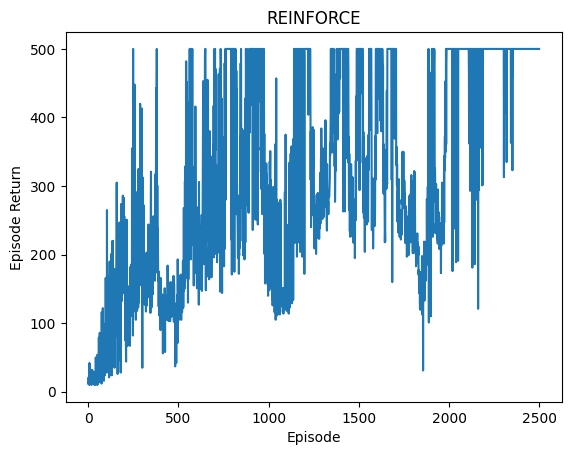

In [22]:
# Initial learn state
REINFORCE_learn_state = REINFORCELearnState(REINFORCE_optim_state)

# Run training loop
print("Starting training. This may take a few minutes to complete.")
episode_returns, evaluator_returns = run_training_loop(
                                        env_name,
                                        REINFORCE_params,
                                        REINFORCE_choose_action_jit,
                                        None, # action state not used
                                        REINFORCE_learn_jit,
                                        REINFORCE_learn_state,
                                        REINFORCE_memory,
                                        num_episodes=2500,
                                        learn_steps_per_episode=2,
                                        video_subdir="reinforce"
                                      )

# Plot the episode returns
plt.plot(episode_returns)
plt.xlabel("Episode")
plt.ylabel("Episode Return")
plt.title("REINFORCE")
plt.show()


In [30]:
#@title Visualise Policy {display-mode: "form"}
#@markdown Choose an episode number that is a multiple of 100, and **run this cell**.

episode_number = 2400 #@param {type:"number"}

assert (episode_number % 100) == 0, "Episode number must be a multiple of 100 since we only record every 100th episode."

eval_episode_number = int(episode_number / 100 * 8)
video_path = f"./video/reinforce/eval/rl-video-episode-{eval_episode_number}.mp4"

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)